# 3. Bakery Transaction - Regression

베이커리 판매 데이터와 외부 데이터를 활용하여 판매 요인을 찾고 판매량 예측하기<br>
Edinburgh, Scotland 베이커리의 판매 데이터 [Kaggle - Transaction from a bakery](https://www.kaggle.com/sulmansarwar/transactions-from-a-bakery)<br>
Edinburgh, Scotland의 이벤트 데이터 [Local Events of Edinburg](https://edinburghguide.com/events)

<br>

**분석 목표**
- 베이커리 판매에 영향을 주는 요인 찾기
- 베이커리 판매량 예측하기
- 세트 상품으로 출시하면 좋을 조합 제안하기

<br>

---

<br>

[3. Analysis](##3.-Analysis) <br>
　[3-2. Regression](###3-1.-Regression)<br>

## 3. Analysis

**필요한 라이브러리 불러오기**

In [1]:
import pandas as pd
from pandas import Series
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
from scipy.interpolate import interp1d

from sklearn import metrics
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

import warnings
warnings.filterwarnings("ignore")

### 3-1. Regression

- 독립변수: Day_of_Week 요일, holiday 공휴일 여부, event_day 이벤트 여부
- 종속변수: Item 판매량

EDA 과정에서 만들어진 데이터셋 사용

In [2]:
new_bakery = pd.read_pickle('../input/new-bakery/new_bakery.pkl')

In [3]:
new_bakery.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20507 entries, 0 to 21292
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         20507 non-null  object        
 1   Time         20507 non-null  object        
 2   Transaction  20507 non-null  int64         
 3   Item         20507 non-null  object        
 4   Date_Time    20507 non-null  datetime64[ns]
 5   Day_of_Week  20507 non-null  object        
 6   Month        20507 non-null  int64         
 7   Year         20507 non-null  int64         
 8   Hour         20507 non-null  int64         
 9   Session      20506 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 1.7+ MB


In [4]:
new_bakery.head()

,Date,Time,Transaction,Item,Date_Time,Day_of_Week,Month,Year,Hour,Session
0,2016-10-30,09:58:11,1,Bread,2016-10-30 09:58:11,Sunday,10,2016,9,Morning
1,2016-10-30,10:05:34,2,Scandinavian,2016-10-30 10:05:34,Sunday,10,2016,10,Morning
2,2016-10-30,10:05:34,2,Scandinavian,2016-10-30 10:05:34,Sunday,10,2016,10,Morning
3,2016-10-30,10:07:57,3,Hot chocolate,2016-10-30 10:07:57,Sunday,10,2016,10,Morning
4,2016-10-30,10:07:57,3,Jam,2016-10-30 10:07:57,Sunday,10,2016,10,Morning


**공휴일과 로컬 이벤트 날에 대한 컬럼 추가**

새로운 데이터프레임 만들기: 제품, 날짜 + 공휴일, 이벤트 정보

- Edinburgh, Scotland 지역의 공휴일: 2016-12-25, 2016-12-26, 2017-01-01, 2017-01-02
- Edinburgh, Scotland 지역의 이벤트: 2016-11-05, 2016-11-12, 2017-01-28, 2017-02-04, 2017-02-18, 2017-03-04

In [5]:
holiday = ['2016-12-25','2016-12-26','2017-01-01','2017-01-02']
event_day = ['2016-11-05','2016-11-12','2017-01-28','2017-02-04','2017-02-18','2017-03-04']

In [6]:
dates = pd.DatetimeIndex(new_bakery['Date_Time'])
bakery = pd.DataFrame(new_bakery.Item.values, columns=['Item'], index = dates)
bakery.head()

,Item
Date_Time,
2016-10-30 09:58:11,Bread
2016-10-30 10:05:34,Scandinavian
2016-10-30 10:05:34,Scandinavian
2016-10-30 10:07:57,Hot chocolate
2016-10-30 10:07:57,Jam


**일 단위로 데이터 샘플링**

데이터 처리 및 시계열 분해의 편의성을 위해 날짜를 인덱스로 데이터프레임을 생성한다

In [7]:
bakery_daily = bakery.resample('D').count()
bakery_daily.head()

,Item
Date_Time,
2016-10-30,170
2016-10-31,199
2016-11-01,150
2016-11-02,164
2016-11-03,189


공휴일이 bakery_daily에 있다면 1, 없다면 0으로 구성되는 열 추가하기

이벤트가 bakery_daily에 있다면 1, 없다면 0으로 구성되는 열 추가하기

In [8]:
bakery_daily['event_day'] = np.where(bakery_daily.index.isin(event_day),1, 0)
bakery_daily['holiday'] = np.where(bakery_daily.index.isin(holiday),1, 0)
bakery_daily.head()

,Item,event_day,holiday
Date_Time,,,
2016-10-30,170,0,0
2016-10-31,199,0,0
2016-11-01,150,0,0
2016-11-02,164,0,0
2016-11-03,189,0,0


<AxesSubplot:>

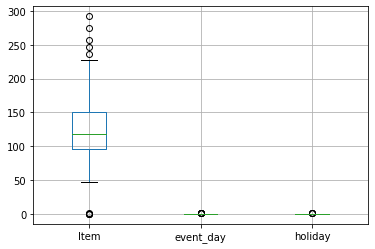

In [9]:
bakery_daily.boxplot()

In [10]:
bakery_daily.describe()

,Item,event_day,holiday
count,162.000000,162.000000,162.000000
mean,126.586420,0.037037,0.024691
std,47.903065,0.189438,0.155664
min,0.000000,0.000000,0.000000
25%,95.750000,0.000000,0.000000
50%,118.000000,0.000000,0.000000
75%,150.750000,0.000000,0.000000
max,292.000000,1.000000,1.000000


공휴일에 판매가 일어났는데 이는 특이한 경우라고 볼 수 있으므로 모델링의 정확성을 위해 제거하여 분석한다

In [11]:
bakery_daily[bakery_daily['holiday'] == 1]['Item']

Date_Time
2016-12-25    0
2016-12-26    0
2017-01-01    1
2017-01-02    0
Name: Item, dtype: int64

In [12]:
bakery_daily.loc[bakery_daily['Item'] == 1, 'Item'] = 0

<AxesSubplot:>

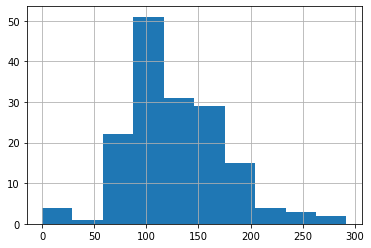

In [13]:
bakery_daily['Item'].hist()

**시계열 분해 (STL Decompose)**

시계열적인 특성을 보이는 데이터를 trend, seasonal, residual로 나누어 분석한다.

bakery_daily의 시계열 그래프를 보면 추세가 명확하지는 않지만 예측 가능한 패턴이 존재한다는 것을 알 수 있다. 따라서, origin = trend + seasonal + residual 로 나누어 분석한 모델인 additive 모델을 가정하고 seasonal 계절성을 없애준다

<AxesSubplot:xlabel='Date_Time'>

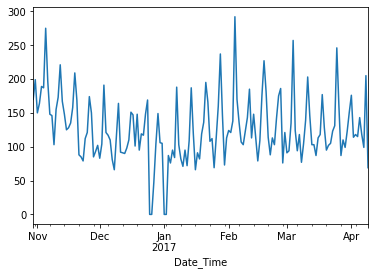

In [14]:
bakery_daily.Item.plot()

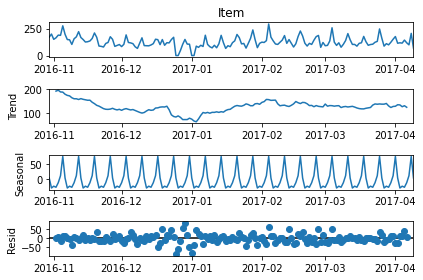

In [15]:
decomposition = sm.tsa.seasonal_decompose(bakery_daily['Item'], model="additive")
ax=decomposition.plot()
plt.show()

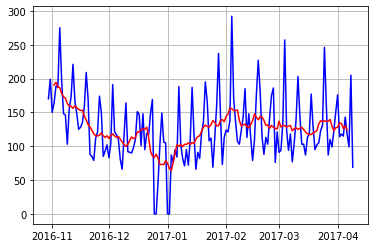

In [16]:
fig, ax = plt.subplots()
ax.grid(True)

plt.plot(bakery_daily.index, bakery_daily['Item'], c='blue')
plt.plot(decomposition.trend.index, decomposition.trend, c='red')

독립변수가 될 수 있는 날짜와 요일 요인을 컬럼으로 넣어준다. 이 때 요일은 범주형 데이터이므로 더미 데이터를 생성하여 적용한다.

In [17]:
bakery_daily['Date'] = bakery_daily.index
bakery_daily['Week_Day'] = bakery_daily.Date.dt.day_name()

In [18]:
bakery_data = pd.get_dummies(bakery_daily)
bakery_data.head()

,Item,event_day,holiday,Date,Week_Day_Friday,Week_Day_Monday,Week_Day_Saturday,Week_Day_Sunday,Week_Day_Thursday,Week_Day_Tuesday,Week_Day_Wednesday
Date_Time,,,,,,,,,,,
2016-10-30,170,0,0,2016-10-30,0,0,0,1,0,0,0
2016-10-31,199,0,0,2016-10-31,0,1,0,0,0,0,0
2016-11-01,150,0,0,2016-11-01,0,0,0,0,0,1,0
2016-11-02,164,0,0,2016-11-02,0,0,0,0,0,0,1
2016-11-03,189,0,0,2016-11-03,0,0,0,0,1,0,0


**상관관계 확인**

상관 행렬과 heatmap에서 0.5가 넘어가는 변수들의 상관관계가 빈번하지 않은 편이므로 다중공선성의 가능성은 낮다고 볼 수 있다. 또한, 분산팽창요인 VIF이 10보다 작으므로 다중공선성의 가능성은 낮다.

In [26]:
bakery_data.corr()

,Item,event_day,holiday,Week_Day_Friday,Week_Day_Monday,Week_Day_Saturday,Week_Day_Sunday,Week_Day_Thursday,Week_Day_Tuesday,Week_Day_Wednesday
Item,1.000000,0.512835,-0.421600,0.078729,-0.217448,0.627027,0.020396,-0.098237,-0.192273,-0.218559
event_day,0.512835,1.000000,-0.031204,-0.079776,-0.079776,0.482122,-0.081786,-0.079776,-0.079776,-0.079776
holiday,-0.421600,-0.031204,1.000000,-0.064723,0.163214,-0.064723,0.157591,-0.064723,-0.064723,-0.064723
Week_Day_Friday,0.078729,-0.079776,-0.064723,1.000000,-0.165468,-0.165468,-0.169638,-0.165468,-0.165468,-0.165468
Week_Day_Monday,-0.217448,-0.079776,0.163214,-0.165468,1.000000,-0.165468,-0.169638,-0.165468,-0.165468,-0.165468
Week_Day_Saturday,0.627027,0.482122,-0.064723,-0.165468,-0.165468,1.000000,-0.169638,-0.165468,-0.165468,-0.165468
Week_Day_Sunday,0.020396,-0.081786,0.157591,-0.169638,-0.169638,-0.169638,1.000000,-0.169638,-0.169638,-0.169638
Week_Day_Thursday,-0.098237,-0.079776,-0.064723,-0.165468,-0.165468,-0.165468,-0.169638,1.000000,-0.165468,-0.165468
Week_Day_Tuesday,-0.192273,-0.079776,-0.064723,-0.165468,-0.165468,-0.165468,-0.169638,-0.165468,1.000000,-0.165468
Week_Day_Wednesday,-0.218559,-0.079776,-0.064723,-0.165468,-0.165468,-0.165468,-0.169638,-0.165468,-0.165468,1.000000


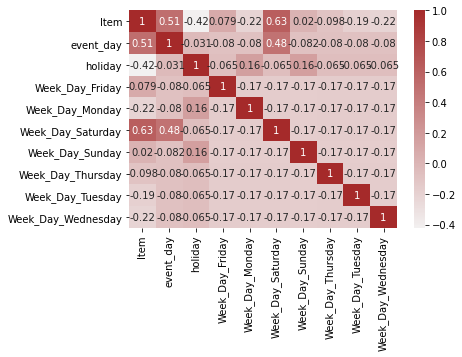

In [25]:
import seaborn as sns                        

cmap = sns.light_palette("brown", as_cmap = True)  
sns.heatmap(bakery_data.corr(), annot = True, cmap = cmap)
plt.show()

In [24]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(bakery_data.values, i) for i in range(bakery_data.shape[1])]
vif["features"] = bakery_data.columns
vif

,VIF Factor,features
0,3.112084,Item
1,1.536965,event_day
2,1.584814,holiday
3,4.571879,Week_Day_Friday
4,3.474981,Week_Day_Monday
5,7.774411,Week_Day_Saturday
6,4.970888,Week_Day_Sunday
7,3.562444,Week_Day_Thursday
8,3.094098,Week_Day_Tuesday
9,2.971628,Week_Day_Wednesday


**Train data와 Test data 나누기**

In [23]:
X = bakery_data[bakery_data.columns.difference(['Item'])]
y = bakery_data['Item']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

129 33
129 33


**모델 적합 - 다중 선형 회귀 LinearRegression**

**모델 튜닝**

절편의 여부와 정규화의 여부에 따라 하이퍼파라미터를 조정해야하는데 가능한 모델의 경우를 모두 구해서 모델 fit 결과를 알려주고 가장 적합한 경우를 알려준다.

이를 토대로 다중선형회귀 모델을 적합한다.

사이킷런의 교차 검증 기능은 scoring 매개변수에 비용함수가 아니라 효용함수를 기대하기 때문에, 즉 값이 클수록 좋은 경우로 판단되기 때문에 평균 제곱오차 (MSE)의 음수값을 사용한다.

**💫 invalid type promotion 에러가 발생하는 이유**

연-월-일 형태의 datetime64[ns]가 포함되었기 때문 → Date 항목은 인덱스로 들어가 있으므로 Date 컬럼을 제거해준다.

In [22]:
bakery_data = bakery_data.drop(['Date'], axis=1)
bakery_data

,Item,event_day,holiday,Week_Day_Friday,Week_Day_Monday,Week_Day_Saturday,Week_Day_Sunday,Week_Day_Thursday,Week_Day_Tuesday,Week_Day_Wednesday
Date_Time,,,,,,,,,,
2016-10-30,170,0,0,0,0,0,1,0,0,0
2016-10-31,199,0,0,0,1,0,0,0,0,0
2016-11-01,150,0,0,0,0,0,0,0,1,0
2016-11-02,164,0,0,0,0,0,0,0,0,1
2016-11-03,189,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
2017-04-05,143,0,0,0,0,0,0,0,0,1
2017-04-06,118,0,0,0,0,0,0,1,0,0
2017-04-07,99,0,0,1,0,0,0,0,0,0


In [41]:
# 파라미터 이름은 정의된 이름 그대로를 사용해야한다 
parameter_cases = {
    'fit_intercept': [True, False],
    'normalize': [False, True]
}

lm = LinearRegression()

estimator = GridSearchCV(lm, param_grid = parameter_cases, 
                         scoring="neg_mean_squared_error", cv=3,
                         return_train_score=True, iid=True)

results = estimator.fit(X_train, y_train)
print(results.best_estimator_)

LinearRegression()


In [42]:
pd.DataFrame(results.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_fit_intercept,param_normalize,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.004411,0.000154,0.002488,0.000099,True,False,"{'fit_intercept': True, 'normalize': False}",-762.460354,-837.065086,-1114.861596,-904.795679,151.629447,1,-839.180022,-761.726767,-676.052619,-758.986469,66.624666
1,0.004385,0.000503,0.002389,0.000049,True,True,"{'fit_intercept': True, 'normalize': True}",-762.460354,-899.813953,-1114.861596,-925.711968,145.028018,4,-839.180022,-776.604651,-676.052619,-763.945764,67.195352
2,0.003558,0.000019,0.002454,0.000162,False,False,"{'fit_intercept': False, 'normalize': False}",-762.460354,-837.065086,-1114.861596,-904.795679,151.629447,2,-839.180022,-761.726767,-676.052619,-758.986469,66.624666
3,0.003775,0.000089,0.002321,0.000075,False,True,"{'fit_intercept': False, 'normalize': True}",-762.460354,-837.065086,-1114.861596,-904.795679,151.629447,2,-839.180022,-761.726767,-676.052619,-758.986469,66.624666


Train Score나 Test Score가 모든 경우에 같기 때문에 큰 차이가 있다고 볼 수 없다. fit_intercept=True, normalize = False 인 모델로 적합을 해보자.

In [43]:
lr = LinearRegression(fit_intercept=True, normalize = False)
lr.fit(X_train, y_train)
print(lr.intercept_, [z for z in zip(X.columns, lr.coef_)])

126.36527944511138 [('Week_Day_Friday', 8.468053888221942), ('Week_Day_Monday', -12.95723346809988), ('Week_Day_Saturday', 56.92043484060289), ('Week_Day_Sunday', 11.560007911210477), ('Week_Day_Thursday', -14.587501667333601), ('Week_Day_Tuesday', -24.920835000666912), ('Week_Day_Wednesday', -24.48292650393493), ('event_day', 60.11428571428571), ('holiday', -121.58045977011496)]


In [44]:
y_pred = lr.predict(X_train)
print(lr.coef_, np.sqrt(mean_squared_error(y_train, lr.predict(X_train))))

[   8.46805389  -12.95723347   56.92043484   11.56000791  -14.58750167
  -24.920835    -24.4829265    60.11428571 -121.58045977] 27.944753247941918


**모델 적합 - 릿지 회귀 Ridge Regression**

**모델 튜닝**

마찬가지로 알파의 범위를 logspace(-10,10, 20)로 두고 Ridge 모델에서 사용할 최적의 알파 값을 찾아보자.

In [47]:
grid = GridSearchCV(estimator=Ridge(),
                    param_grid = {'alpha': np.logspace(-10,10, 20)},
                    scoring="neg_mean_squared_error", cv=3,
                    return_train_score=True, iid=True)


grid.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=Ridge(), iid=True,
             param_grid={'alpha': array([1.00000000e-10, 1.12883789e-09, 1.27427499e-08, 1.43844989e-07,
       1.62377674e-06, 1.83298071e-05, 2.06913808e-04, 2.33572147e-03,
       2.63665090e-02, 2.97635144e-01, 3.35981829e+00, 3.79269019e+01,
       4.28133240e+02, 4.83293024e+03, 5.45559478e+04, 6.15848211e+05,
       6.95192796e+06, 7.84759970e+07, 8.85866790e+08, 1.00000000e+10])},
             return_train_score=True, scoring='neg_mean_squared_error')

In [48]:
print(np.sqrt(-grid.best_score_), grid.best_params_)

30.079821784779085 {'alpha': 1e-10}


In [49]:
best_model = grid.best_estimator_
np.sqrt(mean_squared_error(y_test, best_model.predict(X_test)))

24.045317672416132

**적합 결과 확인**

In [50]:
ridge = Ridge(alpha=1e-10, normalize=False)
ridge.fit(X_train, y_train)
print(ridge.coef_, np.sqrt(mean_squared_error(y_train, ridge.predict(X_train))))

[   8.46833333  -12.95695403   56.92071428   11.56028735  -14.58722223
  -24.92055556  -24.48264706   60.11428571 -121.58045977] 27.944753247941918


<AxesSubplot:title={'center':'Coefficient with Ridge'}>

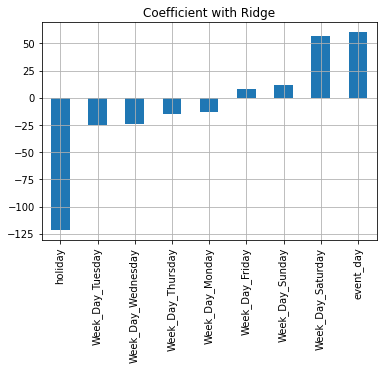

In [51]:
predictors = X_train.columns
coefRidge = Series(ridge.coef_, predictors).sort_values()
coefRidge.plot(kind='bar', title='Coefficient with Ridge', grid=True)

**모델 적합 - 라쏘 회귀 Lasso Regression**

In [52]:
lasso = Lasso(normalize=False)
lasso.fit(X_train, y_train)

Lasso()

<AxesSubplot:title={'center':'Coefficient with Lasso'}>

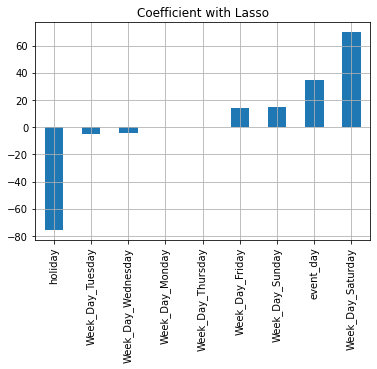

In [53]:
predictors = X_train.columns
coefLasso = Series(lasso.coef_, predictors).sort_values()
coefLasso.plot(kind='bar', title='Coefficient with Lasso', grid=True)

**모델 성능 비교**

다중선형모델과 Ridge, Lasso 모델 적합 결과의 RMSE와 scores (결정계수)의 값으로 성능을 비교해보자.

In [54]:
fit_results = pd.DataFrame(columns=['Model', 'Train_RMSE', 'Test_RMSE', 'Train_Score','Test_Score'], index=range(3))
model_list = [lr, ridge, lasso]

y_pred_mean_train = [y_train.mean()] * len(y_train)
y_pred_mean_test = [y_test.mean()] * len(y_test)

for idx, model in enumerate(model_list):
    rmse_train = np.sqrt(mean_squared_error(y_train, model.predict(X_train)))
    rmse_test = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
    score_train = model.score(X_train, y_train)
    score_test = model.score(X_test, y_test)
    fit_results.loc[idx] = [model, rmse_train, rmse_test, score_train, score_test]
    
fit_results.loc[3] = ['Baseline',  np.sqrt(metrics.mean_squared_error(y_train, y_pred_mean_train)), np.sqrt(metrics.mean_squared_error(y_test, y_pred_mean_test)),0.0, 0.0]
    
fit_results

,Model,Train_RMSE,Test_RMSE,Train_Score,Test_Score
0,LinearRegression(),27.944753,24.045318,0.658291,0.745165
1,Ridge(alpha=1e-10),27.944753,24.045318,0.658291,0.745165
2,Lasso(),29.738836,28.273159,0.613007,0.647672
3,Baseline,47.804886,47.632219,0.0,0.0


In [55]:
fit_results.index = fit_results.Model

<AxesSubplot:title={'center':'Score for test'}, ylabel='Model'>

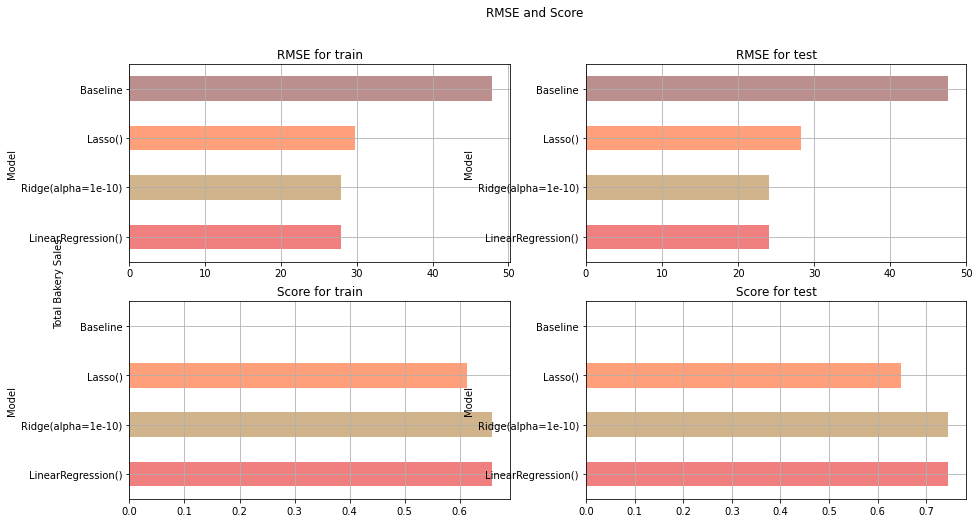

In [56]:
fig, axes = plt.subplots(2, 2, figsize=(15,8), sharex=False, sharey=False, squeeze=False)
fig.suptitle('RMSE and Score', fontsize=12)
fig.text(0.06, 0.5, 'Total Bakery Sales', ha='center', va='center', rotation='vertical')

RMSE_train_graph = fit_results['Train_RMSE']
RMSE_train_graph.plot(ax=axes[0][0], grid=True, kind='barh', title='RMSE for train', color=['lightcoral', 'tan', 'lightsalmon','rosybrown'])

RMSE_test_graph = fit_results['Test_RMSE']
RMSE_test_graph.plot(ax=axes[0][1], grid=True, kind='barh', title='RMSE for test', color=['lightcoral', 'tan', 'lightsalmon','rosybrown'])

score_train_graph = fit_results['Train_Score']
score_train_graph.plot(ax=axes[1][0], grid=True, kind='barh', title='Score for train', color=['lightcoral', 'tan', 'lightsalmon','rosybrown'])

score_test_graph = fit_results['Test_Score']
score_test_graph.plot(ax=axes[1][1], grid=True, kind='barh', title='Score for test', color=['lightcoral', 'tan', 'lightsalmon','rosybrown'])

In [57]:
results_pred_train = pd.DataFrame({'Actual': y_train, 
                                   'LR_Pred': lr.predict(X_train), 
                                   'Lasso_Pred': lasso.predict(X_train), 
                                   'Ridge_Pred': ridge.predict(X_train)}) 
results_pred_train.describe()

,Actual,LR_Pred,Lasso_Pred,Ridge_Pred
count,129.000000,129.000000,129.000000,129.000000
mean,126.387597,126.387597,126.387597,126.387597
std,47.991261,38.937784,31.185471,38.937784
min,0.000000,-8.172414,37.965750,-8.172414
25%,95.000000,101.882353,109.470654,101.882353
50%,117.000000,113.408046,113.615118,113.408046
75%,151.000000,137.925287,128.717868,137.925287
max,275.000000,243.400000,217.599968,243.400000


<AxesSubplot:>

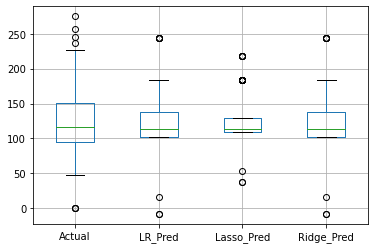

In [58]:
results_pred_train.boxplot()

<AxesSubplot:xlabel='Date_Time'>

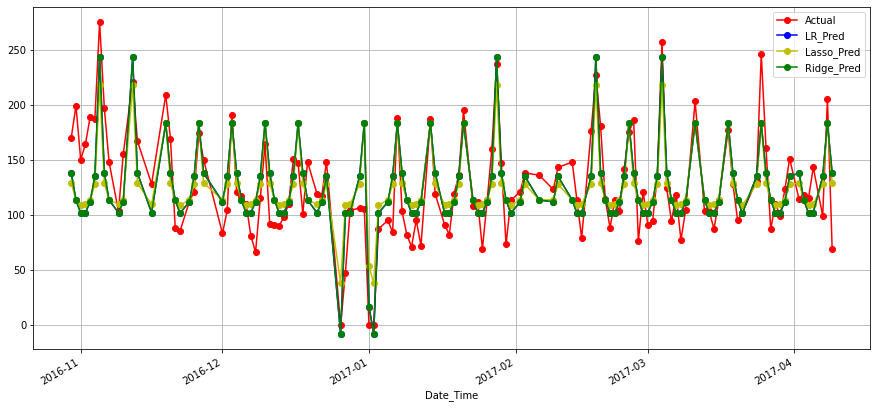

In [59]:
results_pred_train[['Actual', 'LR_Pred', 'Lasso_Pred', 'Ridge_Pred']].plot(figsize=(15,7), style={'Actual': '-or', 'LR_Pred': '-ob', 'Lasso_Pred': '-oy', 'Ridge_Pred': '-og'}, grid=True)

In [60]:
results_pred_train.sort_values(by=['Actual'])

,Actual,LR_Pred,Lasso_Pred,Ridge_Pred
Date_Time,,,,
2017-01-01,0,16.344828,53.068500,16.344828
2017-01-02,0,-8.172414,37.965750,-8.172414
2016-12-26,0,-8.172414,37.965750,-8.172414
2016-12-27,47,101.444444,108.610880,101.444444
2016-12-08,66,111.777778,113.615118,111.777778
...,...,...,...,...
2017-02-18,227,243.400000,217.599968,243.400000
2017-01-28,237,243.400000,217.599968,243.400000
2017-03-25,246,183.285714,183.283459,183.285714


In [61]:
results_pred_test = pd.DataFrame({'Actual': y_test, 
                                  'LR_Pred': lr.predict(X_test)
                                  ,'Lasso_Pred': lasso.predict(X_test),
                                  'Ridge_Pred': ridge.predict(X_test)}) 
results_pred_test.describe()

,Actual,LR_Pred,Lasso_Pred,Ridge_Pred
count,33.000000,33.000000,33.000000,33.000000
mean,127.333333,122.821186,123.712554,122.821186
std,48.370747,37.194328,29.476042,37.194328
min,0.000000,16.344828,53.068500,16.344828
25%,103.000000,101.882353,109.470654,101.882353
50%,123.000000,111.777778,113.615118,111.777778
75%,149.000000,134.833333,127.664940,134.833333
max,292.000000,243.400000,217.599968,243.400000


<AxesSubplot:>

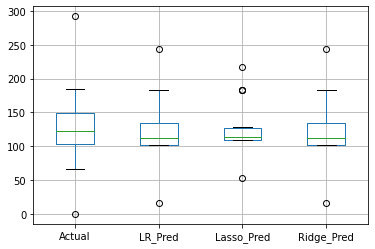

In [62]:
results_pred_test.boxplot()

<AxesSubplot:xlabel='Date_Time'>

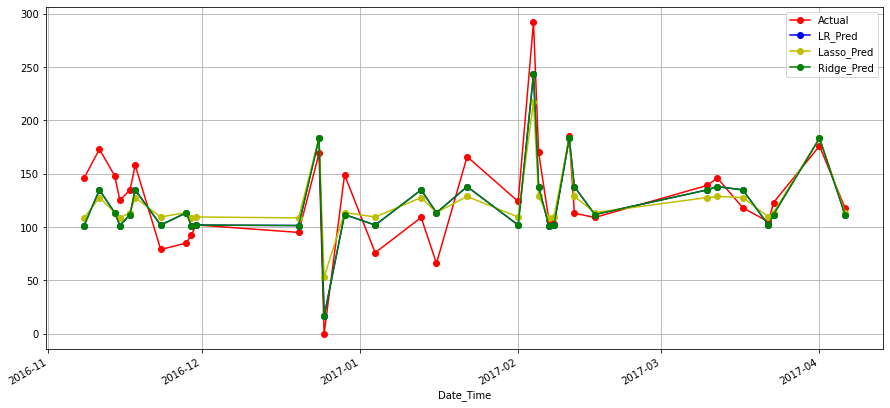

In [63]:
results_pred_test[['Actual', 'LR_Pred', 'Lasso_Pred', 'Ridge_Pred']].plot(figsize=(15,7), style={'Actual': '-or', 'LR_Pred': '-ob', 'Lasso_Pred': '-oy', 'Ridge_Pred': '-og'}, grid=True)

In [64]:
results_pred_test.sort_index()

,Actual,LR_Pred,Lasso_Pred,Ridge_Pred
Date_Time,,,,
2016-11-08,146,101.444444,108.610880,101.444444
2016-11-11,173,134.833333,127.664940,134.833333
2016-11-14,148,113.408046,113.615118,113.408046
2016-11-15,125,101.444444,108.610880,101.444444
2016-11-17,135,111.777778,113.615118,111.777778
2016-11-18,158,134.833333,127.664940,134.833333
2016-11-23,79,101.882353,109.470654,101.882353
2016-11-28,85,113.408046,113.615118,113.408046
2016-11-29,93,101.444444,108.610880,101.444444


---

### Conclusion of Regression 
<br>

- 베이커리의 일일 판매량을 예측하기 위한 최적의 모델은 다중 선형 회귀 모델이다.

```
Items = 8.46805389 Week_Day_Friday -12.95723347 Week_Day_Monday +  56.92043484 Week_Day_Saturday + 11.56000791 Week_Day_Sunday   + -14.58750167 Week_Day_Thursday  -24.920835 Week_Day_Tuesday  + -24.4829265 Week_Day_Wednesday  + 60.11428571 event_day  -121.58045977 holiday
```
<br>

- 다만, 변수가 너무 많기 때문에 변수 선택이나 변수 축소 과정을 통해 영향력 높은 변수만을 추려낼 필요가 있다.
- 설명력은 다중 선형 회귀 모형과 Ridge 회귀 모형이 0.745165로 높았고 RMSE 또한  다중 선형 회귀 모형과 Ridge 회귀 모형이 24.045318로 가장 낮았다.
- 다중 선형 회귀 모형과 Ridge 회귀 모형의 평가지표가 같은 이유는 주어진 데이터에 다중공선성의 영향력이 매우 미미하기 때문이라고 볼 수 있다.
- 일일 판매량에 가장 큰 영향을 주는 변수는 holiday 즉, 공휴일 변수이다.